# Financial Inclusion in Africa

Here we are going to describe and implement a solution to predicting whether an individual feature
set is likely to have a back account or not.

We begin by getting our tools in order, so we will be importing the basic data manipulation utilities,
plotting functions and finally, our model of choice.

###### For Data Processing

In [1]:
import numpy as np
import pandas as pd
import imblearn as il
import seaborn as sns
import matplotlib.pyplot as plt

###### For Display

In [2]:
from mpl_toolkits.mplot3d import Axes3D

###### For Machine Learning

In [3]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import cross_val_score, StratifiedKFold
from category_encoders import TargetEncoder


We will just disable any warnings here.

In [4]:
import warnings
warnings.filterwarnings('ignore')

### Read Files

We then read in our source files with the training and testing data that we will need, we will also
read in and show the variable definitions file to get the sentiment behind the data provided.

In [5]:
# load files into a pandas dataframe
train = pd.read_csv('assets/train.csv')
test = pd.read_csv('assets/test.csv')

# we get the variable definitions
definitions = pd.read_csv('assets/definitions.csv')
definitions.head()

,Variable Definitions,Unnamed: 1
0,country,Country interviewee is in.
1,year,Year survey was done in.
2,uniqueid,Unique identifier for each interviewee
3,location_type,"Type of location: Rural, Urban"
4,cellphone_access,"If interviewee has access to a cellphone: Yes, No"


##### A preview of the training data

In [6]:
train.head()

,country,year,uniqueid,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,2018,uniqueid_1,Yes,Rural,Yes,3,24,Female,Spouse,Married/Living together,Secondary education,Self employed
1,Kenya,2018,uniqueid_2,No,Rural,No,5,70,Female,Head of Household,Widowed,No formal education,Government Dependent
2,Kenya,2018,uniqueid_3,Yes,Urban,Yes,5,26,Male,Other relative,Single/Never Married,Vocational/Specialised training,Self employed
3,Kenya,2018,uniqueid_4,No,Rural,Yes,5,34,Female,Head of Household,Married/Living together,Primary education,Formally employed Private
4,Kenya,2018,uniqueid_5,No,Urban,No,8,26,Male,Child,Single/Never Married,Primary education,Informally employed


## Combine train and test set for easy preprocessing

In [7]:
# mapping the bank account with 0 to NO and 1 to YES
train['bank_account'] = train['bank_account'].map({'No':0, 'Yes':1})
# Combine train and test set
ntrain = train.shape[0]

all_data = pd.concat((train, test)).reset_index(drop=True)

### Feature Engineering

Here we select the variables that are useful as described in the definitions file. So we will probably
not need to ``uniqueid`` or ``bank_account`` since first does not relate to the sentiment and the latter
is what we are trying to predict accurately.

We have chosen target encoding because it keeps the parameters of our data the same and does not expand
the data set.

In [8]:
# Select main columns to be used in training
main_cols = all_data.columns.difference(['uniqueid', 'bank_account'])
encoder = TargetEncoder(cols=main_cols)

temp = encoder.fit_transform(all_data, all_data['bank_account'])
temp['bank_account'] = all_data['bank_account']
temp['origin'] = all_data['country']
all_data = temp

all_data.head()

,country,year,uniqueid,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type,origin
0,0.250659,0.208349,uniqueid_1,1.0,0.116503,0.183797,0.142602,0.144128,0.106795,0.106595,0.173598,0.232773,0.131738,Kenya
1,0.250659,0.208349,uniqueid_2,0.0,0.116503,0.017133,0.149667,0.112727,0.106795,0.177149,0.090103,0.038981,0.202429,Kenya
2,0.250659,0.208349,uniqueid_3,1.0,0.178739,0.183797,0.149667,0.183740,0.189696,0.098802,0.121007,0.570361,0.131738,Kenya
3,0.250659,0.208349,uniqueid_4,0.0,0.116503,0.183797,0.149667,0.164751,0.106795,0.177149,0.173598,0.085451,0.541232,Kenya
4,0.250659,0.208349,uniqueid_5,0.0,0.178739,0.017133,0.114514,0.183740,0.189696,0.086586,0.121007,0.085451,0.079507,Kenya


We plot a 3D scatter chart to get an idea of the clusters that form up on the different variables. The
visual helps us make a few decisions on what to do next with our data. So here we will show the
``age_of_respondent``, ``education_level``, and the ``household_size``.

We can clearly see three points on the scatter plot above.
- The data we have is not balanced in that there are more samples on individuals who do not have
bank accounts.
- To the individuals that have accounts, there are clusters that form over certain parameters
- The higher density areas of the plot mostly consists of people without bank accounts.

With these notes, we then begin splitting our data set so that we can work our training data.

In [9]:
# Separate train and test data from the combined dataframe
train_df = all_data[:ntrain]
test_df = all_data[ntrain:]

### Data balancing and Resampling

Since we saw that our data was not balanced we will need to select a balancing method. That said, we
noted that our data has a minority set and also that both the minority and majority data tends to
cluster. From this, we have chosen to use *Synthetic Minority Oversampling Technique (SMOTE)* with a
*K-Nearest Neighbors (KNN)* clustering mechanic where *``k``* is set optimally at *``20``*. From this
resampled set we can then make our training data and testing data.

In [10]:
oversample = il.over_sampling.SMOTE(k_neighbors=20, random_state=42)
borderline = il.over_sampling.BorderlineSMOTE(k_neighbors=20, random_state=42)
svm = il.over_sampling.SVMSMOTE(k_neighbors=20, random_state=42)

x, y = train_df[main_cols], train_df['bank_account']
x, y = oversample.fit_resample(x, y)
# lets take a look now

# Split data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.26, random_state=42, stratify=y)

x_train.head()

,age_of_respondent,cellphone_access,country,education_level,gender_of_respondent,household_size,job_type,location_type,marital_status,relationship_with_head,year
18423,0.084337,0.017133,0.091692,0.038981,0.106795,0.191037,0.094974,0.178739,0.090103,0.177149,0.091692
1833,0.000348,0.017133,0.250659,0.038981,0.189696,0.144214,0.094974,0.178739,0.173598,0.177149,0.208349
34624,0.139683,0.183797,0.250659,0.570361,0.189696,0.141193,0.775194,0.116503,0.173598,0.177149,0.208349
18007,0.167614,0.183797,0.091692,0.085451,0.106795,0.118378,0.131738,0.178739,0.090103,0.177149,0.091692
22270,0.167112,0.183797,0.086149,0.085451,0.106795,0.191037,0.181481,0.116503,0.173598,0.106595,0.208349


### Modelling & Hyperparameter Optimization

We now start modelling and training. Our model of choice as specified in the imports is the XGBoost
model. We choose this model because of its proficiency in accuracy.

We also define an optimization function, we will only have run it once because of the time it takes.
We optimize using a random search algorithm that takes a hyperparameter space it will try to
optimize.

In [11]:
def modeller(params):
    model = XGBClassifier(learning_rate = params[0],
                            n_estimators = params[1],
                            max_depth = params[2],
                            min_child_weight = params[3],
                            gamma = params[4],
                            subsample = params[5],
                            colsample_bytree = params[6],
                            seed = 42,
                            verbosity=0)
    auc = cross_val_score(model, x_train, y_train, cv = 10, scoring = 'roc_auc')
    print(auc.mean())
    return -auc.mean()

# then we define a tuning space for our random forest algo to optimize in
space = [(1e-3, 1e-1, 'log-uniform'), # learning rate
          (100, 2400), # n_estimators
          (1, 64), # max_depth
          (1, 6.), # min_child_weight
          (0, 0.5), # gamma
          (0.1, 1.), # subsample
          (0.1, 1.)] # colsample_bytree
# then we optimize
result = [0.014, 1400, 80, 6., 0.01297998739050575, 0.6336707906620142, 0.1859693229517501]
# result = forest_minimize(modeller, space, random_state = 42, n_random_starts = 20, n_calls  = 20, verbose = 1).x
# print(result)

### Training & Predictions

With the hyper-parameters optimized above we can then instantiate our model and train it. We will
then print the accuracy we get out.

In [12]:
model = XGBClassifier(learning_rate = result[0],
                        n_estimators = result[1],
                        max_depth = result[2],
                        min_child_weight = result[3],
                        gamma = result[4],
                        subsample = result[5],
                        colsample_bytree = result[6],
                        eval_metric='logloss',
                        seed = 42)

kfold = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
scores = cross_val_score(model, x, y, scoring='accuracy', cv=kfold, n_jobs=-1)
print('Accuracy: %.3f (%.3f) - Maximum %.3f' % (np.mean(scores), np.std(scores), np.max(scores)))

eval_s = [(x, y), (x_test, y_test)]
model.fit(x_train, y_train, eval_set=eval_s, verbose=0)

y_pred = model.predict(x_test)

print(f'XGBoost model accuracy score: {round(accuracy_score(y_pred, y_test) * 100, 2)}%')
print(f'XGBoost model F1 score: {round(f1_score(y_pred, y_test) * 100, 2)}%')
# Make prediction on the test set

test_df['bank_account'] = model.predict(test_df[main_cols])
test_df['bank_account'] = test_df['bank_account'].astype(int)

Accuracy: 0.931 (0.006) - Maximum 0.940
XGBoost model accuracy score: 92.9%
XGBoost model F1 score: 92.64%


### Monitoring Learning Rate

Before anything we will display some of the metrics needed to further tune and monitor the model
we have iteratively.

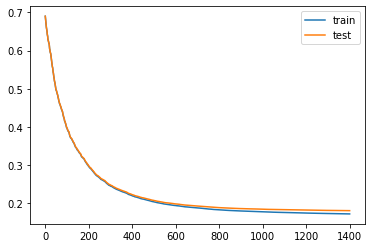

In [13]:
results = model.evals_result()
# files.download('Baseline.csv')
plt.plot(results['validation_0']['logloss'], label='train')
plt.plot(results['validation_1']['logloss'], label='test')
# show the legend
plt.legend()
# show the plot
plt.show()

### Create Submission File

We create our submission file as per the submission template provided.

In [14]:
# Create a submission file
sub_file = test_df.copy()

sub_file['unique_id'] = sub_file.apply(lambda k: f'{k["uniqueid"]} x {k["origin"]}', axis=1)
sub_file = sub_file.filter(['unique_id', 'bank_account'], axis=1)
# Check the distribution of your predictions
# sns.countplot(sub_file.predictions);

# Create a csv file and upload to zindi
sub_file.to_csv('baseline.csv', index = False)
# files.download('baseline.csv')


### Reccomendations